In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import math
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
import tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

2023-05-10 10:01:02 - ast_utils - DEBUG    - Using cache folder: /var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/game_generation_cache
2023-05-10 10:01:02 - src.ast_utils - DEBUG    - Using cache folder: /var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/game_generation_cache


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


In [4]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,num_preferences_defined_1,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,0,...,0.975633,0.984253,0.970248,0.981414,0.981920,0.983617,0.919078,0.915602,0.974574,0.987096
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,0,...,0.981611,0.982580,0.966645,0.978594,0.977472,0.984273,0.921563,0.931860,0.945369,0.962067
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,1,...,0.975762,0.980443,0.000000,0.000000,0.000000,0.000000,0.844787,0.858832,0.923039,0.942307
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,1,...,0.987207,0.986957,0.000000,0.000000,0.000000,0.000000,0.919078,0.915602,0.974574,0.987096
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0,...,0.982521,0.981108,0.000000,0.000000,0.000000,0.000000,0.976741,0.978090,0.970715,0.987147


In [5]:
postprocessor = ast_parser.ASTSamplePostprocessor()
postprocessed_real_game_texts = [ast_printer.ast_to_string(postprocessor(ast), '\n') for ast in game_asts]  # type: ignore

real_game_edit_distances = np.zeros((len(game_asts), len(game_asts)), dtype=int)
for i, j in itertools.combinations(range(len(game_asts)), 2):
    real_game_edit_distances[i, j] = real_game_edit_distances[j, i] = edit_distance(postprocessed_real_game_texts[i], postprocessed_real_game_texts[j])


def edit_distance(first_game_text: str, second_game_text: str):
    first_game_text = first_game_text[first_game_text.find(')', first_game_text.find('(:domain')) + 1:]
    second_game_text = second_game_text[second_game_text.find(')', second_game_text.find('(:domain')) + 1:]
    return _edit_distance(first_game_text, second_game_text)


def find_nearest_real_game_indices(game, k: int = 3) -> typing.Tuple[np.ndarray, np.ndarray]:
    game_str = ast_printer.ast_to_string(game, '\n')
    distances = np.array([edit_distance(game_str, real_game) for real_game in postprocessed_real_game_texts])
    nearest_real_game_indices = np.argsort(distances)[:k]
    return nearest_real_game_indices, distances[nearest_real_game_indices]


def print_nearest_real_games(game, k: int = 3):
    indices, distances = find_nearest_real_game_indices(game, k)
    for i, (idx, d) in enumerate(zip(indices, distances)):
        real_game_distances = real_game_edit_distances[idx]
        nearest_distance_indices = np.argsort(real_game_distances)[1:k + 1]  # index 0 is the game itself
        display(Markdown(f'### Nearest real game #{i + 1}:'))
        display(Markdown(f'Edit distance to sample {d}, real game nearest neighbor distances {np.array2string(real_game_distances[nearest_distance_indices], separator=", ")}):\n'))
        display(Markdown(f'```pddl\n{real_game_texts[idx]}\n```'))


In [6]:
HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS = dict(hspace=0.3)


def plot_value_histograms(results_by_feature_name_and_value: typing.Dict[str, typing.Dict[int, typing.List[float]]],
    bins: int = 20, histogram_log_y: bool = False, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    k = len(results_by_feature_name_and_value.keys())

    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    for i, feature_name in enumerate(results_by_feature_name_and_value.keys()):
        if layout[0] == 1:
            ax = axes[i]
        else:
            ax = axes[i // layout[1]][i % layout[1]]

        values_with = results_by_feature_name_and_value[feature_name][1]
        values_without = results_by_feature_name_and_value[feature_name][0]

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([values_with, values_without], label=[f'1 (n={len(values_with)})', f'0 (n={len(values_without)})'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Fitness value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title = f'#{i + 1}: {feature_name}'
        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        


def analyze_archive_fullness(model: MAPElitesSampler, mutually_exclusive_features: typing.Optional[typing.List[str]] = None,
                             plot_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    if plot_kwargs is None:
        plot_kwargs = {}
    
    results_by_feature_name = {feature_name: defaultdict(list) for feature_name in model.map_elites_feature_names}
    results_by_feature_count = defaultdict(list)

    for key, fitness_value in model.fitness_values.items():
        for feature_name, feature_value in model._key_to_feature_dict(key).items():
            results_by_feature_name[feature_name][feature_value].append(fitness_value)

        results_by_feature_count[count_set_bits(key)].append(fitness_value)

    display(Markdown(f'## Archive fullness analysis'))
    display(Markdown(f'Ttoal of {len(model.fitness_values)} samples in archive, {len(model.map_elites_feature_names)} features'))
    display(Markdown(f'### Results by feature'))
    lines = []
    for feature_name, results in results_by_feature_name.items():
        lines.append(f'- {feature_name}:')
        for feature_value in sorted(results.keys()):
            value_results = results[feature_value]
            lines.append(f'    - ={feature_value}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)})')

    display(Markdown('\n'.join(lines)))

    display(Markdown(f'### Results by set feature count'))
    lines = []
    for feature_count in sorted(results_by_feature_count.keys()):
        value_results = results_by_feature_count[feature_count]
        lines.append(f'- set-count={feature_count}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)} / {math.comb(len(model.map_elites_feature_names), feature_count)})')

    display(Markdown('\n'.join(lines)))

    plot_value_histograms(results_by_feature_name, **plot_kwargs)


In [7]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)


def plot_sampler_fitness_trajectory(evo: PopulationBasedSampler, title: typing.Optional[str] = None, axsize: typing.Tuple[int, int] = (8, 6),
                                    plot_metrics: typing.Optional[bool] = None, subplots_adjust_params: typing.Dict[str, float] = SUBPLOTS_ADJUST_PARAMS,
                                    min_real_game_fitness: float = 72.8545, max_real_game_fitness: float = 78.0885):
    
    if plot_metrics is None:
        plot_metrics = hasattr(evo, 'archive_metrics_history') and len(evo.archive_metrics_history) > 0
            
    layout = (1, 2) if plot_metrics else (1, 1)
    figsize = (axsize[0] * layout[1], axsize[1])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_metrics else axes)

    fitness_ax.plot(mean, label='mean fitness')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='std')  # type; ignore
    fitness_ax.plot(max_fit, label='max fitness')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='min real game fitness', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), label='max real game fitness', color='black', ls='--')

    fitness_ax.set_xlabel('Generation')
    fitness_ax.set_ylabel('Fitness')

    fitness_ax.legend(loc='best')
    
    if plot_metrics:
        metrics = {key: [] for key in evo.archive_metrics_history[0].keys()}
        for step_dict in evo.archive_metrics_history:
            for key, value in step_dict.items():
                metrics[key].append(value)

        metrics_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        for key, values in metrics.items():
            metrics_ax.plot(values, label=key)

        metrics_ax.set_xlabel('Generation')
        metrics_ax.set_ylabel('Metric Value')

        metrics_ax.legend(loc='best')

        plt.subplots_adjust(**subplots_adjust_params)
        
    if title is not None:
        if plot_metrics:
            plt.suptitle(title)
        else:
            plt.title(title)

    plt.show()


def count_games_above_fitness_threshold(evo: PopulationBasedSampler, threshold: float) -> int:
    if isinstance(evo.fitness_values, dict):
        fitness_values = evo.fitness_values.values()
    else:
        fitness_values = evo.fitness_values

    return sum(1 for fitness in fitness_values if fitness >= threshold)

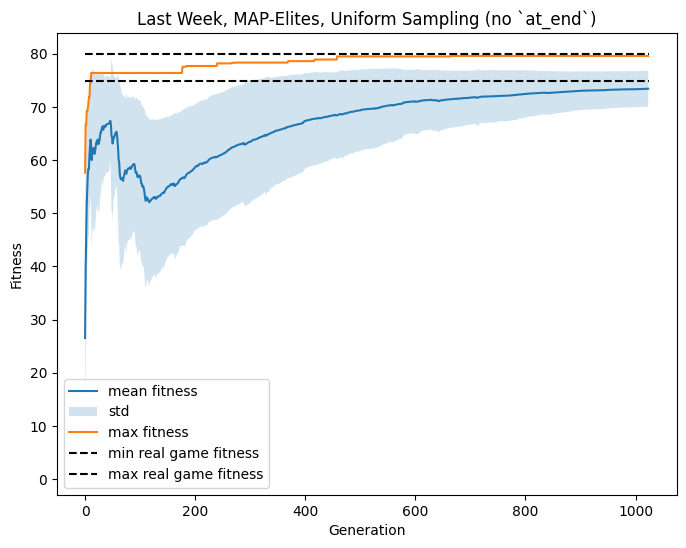

98 254


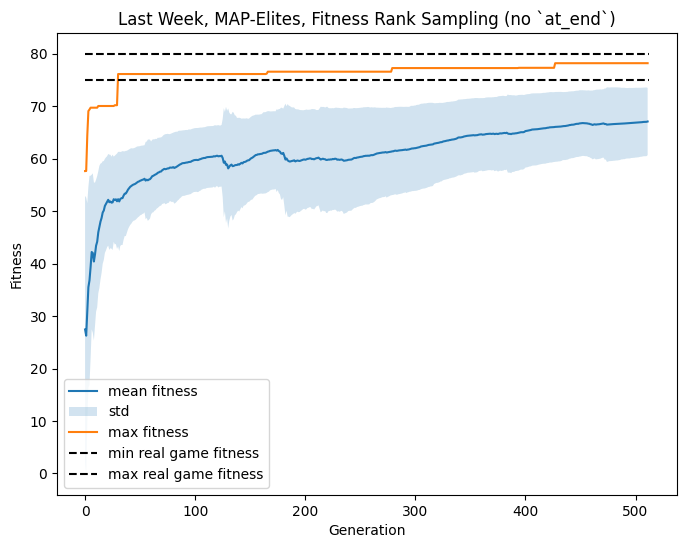

## Archive fullness analysis

Ttoal of 254 samples in archive, 13 features

### Results by feature

- compositionality_structure_0:
    - =0: 73.779 ± 3.255 (n=128)
    - =1: 73.087 ± 3.399 (n=126)
- compositionality_structure_1:
    - =0: 73.605 ± 3.261 (n=128)
    - =1: 73.265 ± 3.421 (n=126)
- compositionality_structure_2:
    - =0: 74.594 ± 3.266 (n=127)
    - =1: 72.278 ± 3.006 (n=127)
- compositionality_structure_3:
    - =0: 74.581 ± 3.183 (n=128)
    - =1: 72.272 ± 3.096 (n=126)
- compositionality_structure_4:
    - =0: 75.117 ± 2.455 (n=128)
    - =1: 71.728 ± 3.264 (n=126)
- compositionality_structure_5:
    - =0: 73.436 ± 3.345 (n=254)
- compositionality_structure_6:
    - =0: 73.641 ± 3.273 (n=128)
    - =1: 73.228 ± 3.405 (n=126)
- compositionality_structure_7:
    - =0: 73.436 ± 3.345 (n=254)
- compositionality_structure_8:
    - =0: 75.050 ± 2.550 (n=128)
    - =1: 71.796 ± 3.259 (n=126)
- compositionality_structure_9:
    - =0: 73.436 ± 3.345 (n=254)
- compositionality_structure_10:
    - =0: 73.436 ± 3.345 (n=254)
- compositionality_structure_11:
    - =0: 73.436 ± 3.345 (n=254)
- compositionality_structure_12:
    - =0: 74.411 ± 3.149 (n=128)
    - =1: 72.445 ± 3.246 (n=126)

### Results by set feature count

- set-count=0: 78.007 ± 0.000 (n=1 / 1)
- set-count=1: 77.741 ± 0.973 (n=8 / 13)
- set-count=2: 76.994 ± 1.550 (n=28 / 78)
- set-count=3: 75.694 ± 1.963 (n=56 / 286)
- set-count=4: 73.709 ± 2.248 (n=70 / 715)
- set-count=5: 71.236 ± 2.139 (n=56 / 1287)
- set-count=6: 69.096 ± 1.860 (n=28 / 1716)
- set-count=7: 67.788 ± 1.163 (n=7 / 1716)

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


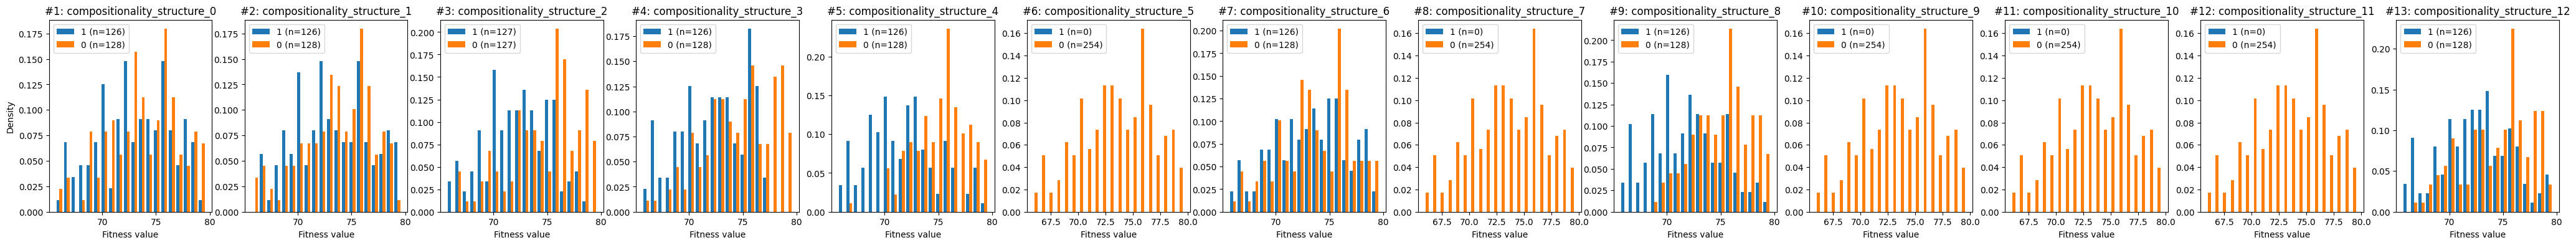

In [8]:
original_uniform = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'b726ded1_map_elites_uniform_final'))
plot_sampler_fitness_trajectory(original_uniform, 'Last Week, MAP-Elites, Uniform Sampling (no `at_end`)',
                                min_real_game_fitness=74.9304, max_real_game_fitness=80.0098)

print(count_games_above_fitness_threshold(original_uniform, 74.9304), len(original_uniform.fitness_values))

original_fitness_rank = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'b726ded1_map_elites_fitness_rank_final'))
plot_sampler_fitness_trajectory(original_fitness_rank, 'Last Week, MAP-Elites, Fitness Rank Sampling (no `at_end`)',
                                min_real_game_fitness=74.9304, max_real_game_fitness=80.0098)

analyze_archive_fullness(original_uniform)

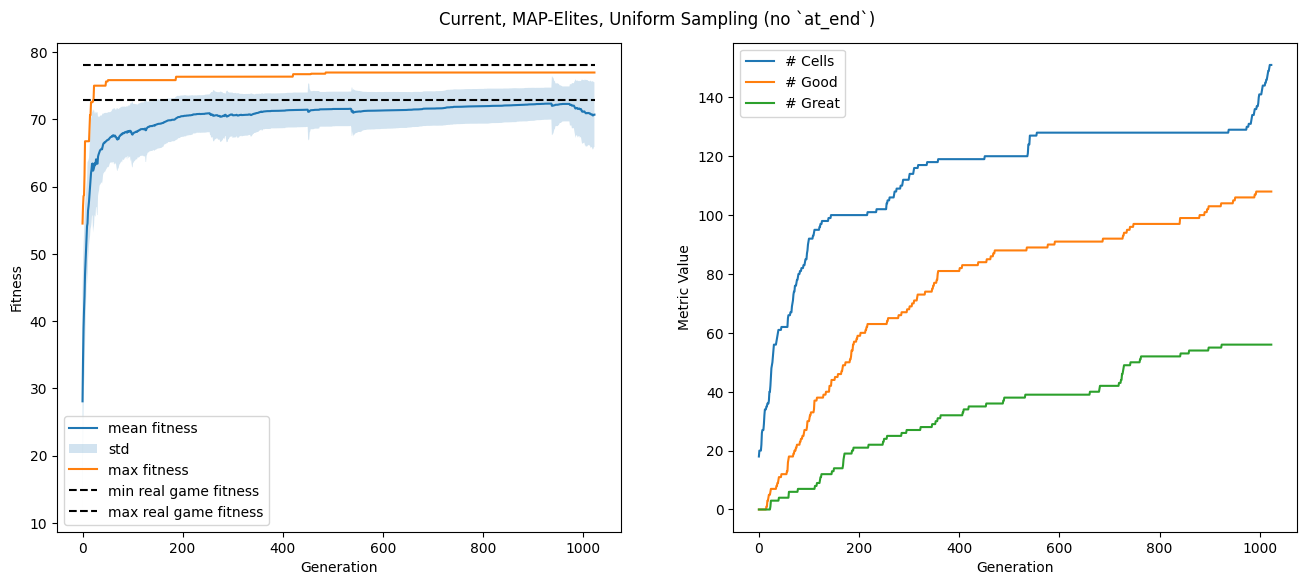

59 151


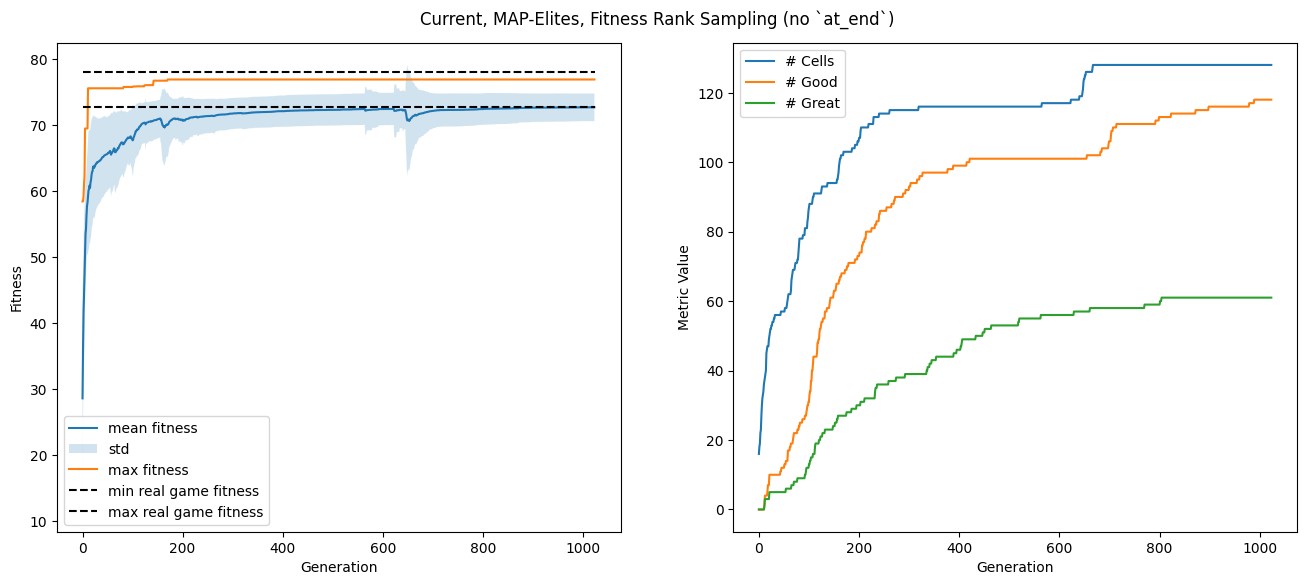

## Archive fullness analysis

Ttoal of 151 samples in archive, 10 features

### Results by feature

- compositionality_structure_0:
    - =0: 68.866 ± 5.306 (n=87)
    - =1: 73.203 ± 2.385 (n=64)
- compositionality_structure_1:
    - =0: 69.489 ± 5.701 (n=87)
    - =1: 72.356 ± 2.427 (n=64)
- compositionality_structure_2:
    - =0: 71.400 ± 5.195 (n=77)
    - =1: 69.980 ± 4.276 (n=74)
- compositionality_structure_3:
    - =0: 70.814 ± 5.672 (n=80)
    - =1: 70.580 ± 3.622 (n=71)
- compositionality_structure_4:
    - =0: 70.242 ± 5.549 (n=85)
    - =1: 71.300 ± 3.585 (n=66)
- compositionality_structure_5:
    - =0: 71.103 ± 4.554 (n=144)
    - =1: 62.506 ± 1.968 (n=7)
- compositionality_structure_6:
    - =0: 69.827 ± 5.773 (n=85)
    - =1: 71.833 ± 2.821 (n=66)
- compositionality_structure_7:
    - =0: 71.047 ± 5.296 (n=79)
    - =1: 70.328 ± 4.203 (n=72)
- compositionality_structure_8:
    - =0: 71.235 ± 4.227 (n=144)
    - =1: 59.786 ± 2.922 (n=7)
- compositionality_structure_9:
    - =0: 71.369 ± 4.114 (n=142)
    - =1: 60.213 ± 2.378 (n=9)

### Results by set feature count

- set-count=0: 73.163 ± 0.000 (n=1 / 1)
- set-count=1: 70.461 ± 6.088 (n=10 / 10)
- set-count=2: 69.585 ± 6.528 (n=32 / 45)
- set-count=3: 70.468 ± 5.673 (n=44 / 120)
- set-count=4: 72.041 ± 1.891 (n=35 / 210)
- set-count=5: 71.353 ± 1.804 (n=21 / 252)
- set-count=6: 69.075 ± 1.522 (n=7 / 210)
- set-count=7: 67.859 ± 0.000 (n=1 / 120)

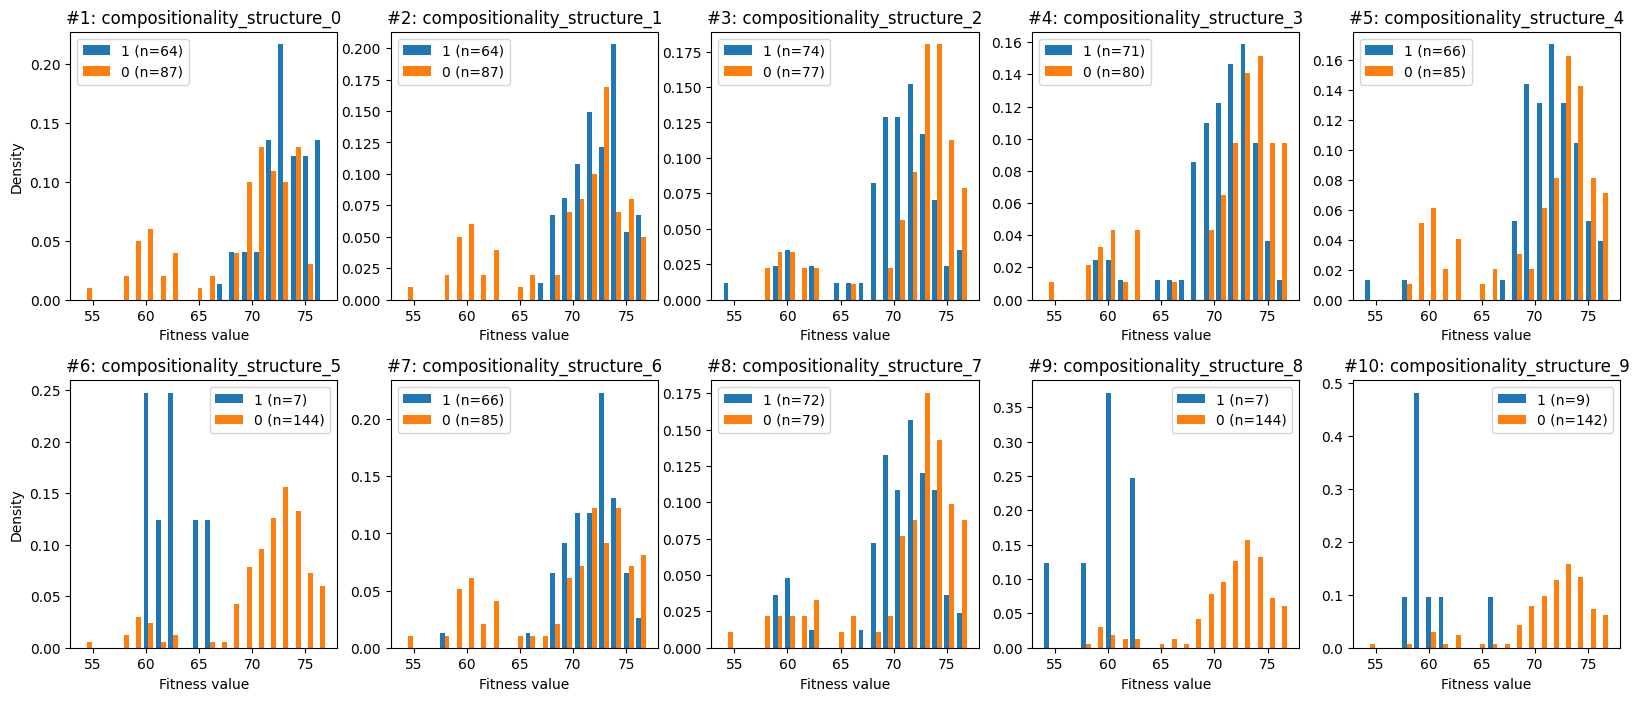

In [9]:
current_uniform = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'evo_sampler_map_elites_uniform_compositionality_final'))
plot_sampler_fitness_trajectory(current_uniform, 'Current, MAP-Elites, Uniform Sampling (no `at_end`)')

print(count_games_above_fitness_threshold(current_uniform, 72.8545), len(current_uniform.fitness_values))

current_fitness_rank = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'evo_sampler_map_elites_fitness_rank_compositionality_final'))
plot_sampler_fitness_trajectory(current_fitness_rank, 'Current, MAP-Elites, Fitness Rank Sampling (no `at_end`)')

analyze_archive_fullness(current_uniform)

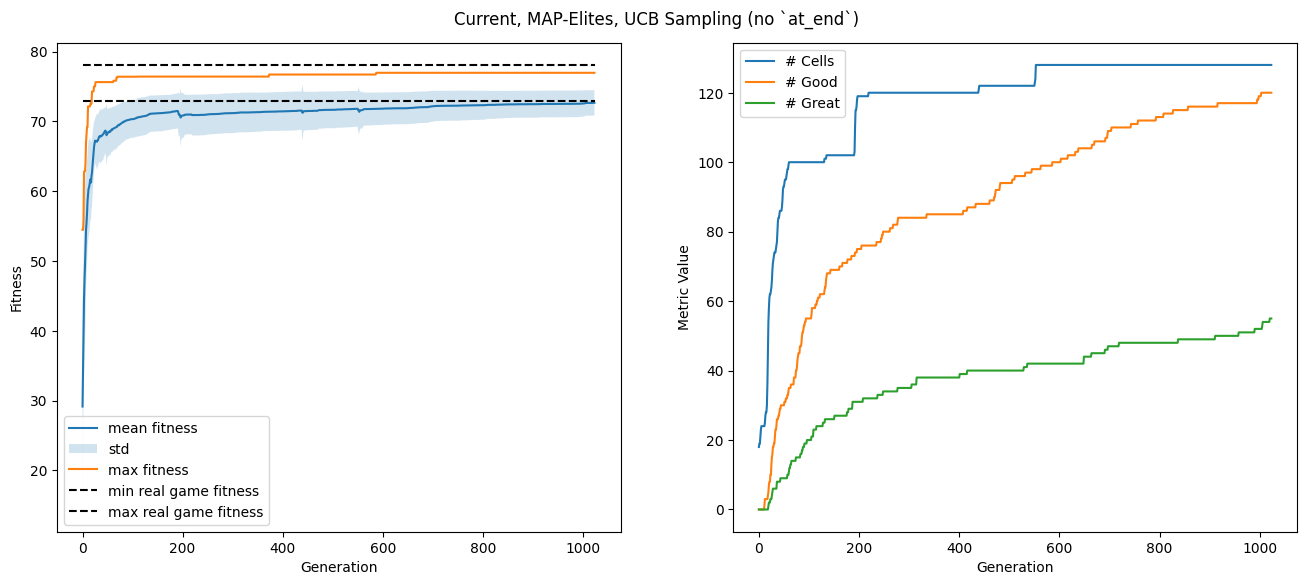

## Archive fullness analysis

Ttoal of 128 samples in archive, 10 features

### Results by feature

- compositionality_structure_0:
    - =0: 71.781 ± 1.575 (n=64)
    - =1: 73.564 ± 1.589 (n=64)
- compositionality_structure_1:
    - =0: 72.837 ± 1.793 (n=64)
    - =1: 72.507 ± 1.823 (n=64)
- compositionality_structure_2:
    - =0: 73.231 ± 1.960 (n=64)
    - =1: 72.113 ± 1.460 (n=64)
- compositionality_structure_3:
    - =0: 73.416 ± 1.737 (n=64)
    - =1: 71.928 ± 1.572 (n=64)
- compositionality_structure_4:
    - =0: 72.896 ± 1.782 (n=64)
    - =1: 72.448 ± 1.822 (n=64)
- compositionality_structure_5:
    - =0: 72.672 ± 1.816 (n=128)
- compositionality_structure_6:
    - =0: 73.059 ± 1.861 (n=64)
    - =1: 72.286 ± 1.683 (n=64)
- compositionality_structure_7:
    - =0: 73.346 ± 1.645 (n=64)
    - =1: 71.999 ± 1.726 (n=64)
- compositionality_structure_8:
    - =0: 72.672 ± 1.816 (n=128)
- compositionality_structure_9:
    - =0: 72.672 ± 1.816 (n=128)

### Results by set feature count

- set-count=0: 73.969 ± 0.000 (n=1 / 1)
- set-count=1: 74.234 ± 0.842 (n=7 / 10)
- set-count=2: 73.804 ± 1.819 (n=21 / 45)
- set-count=3: 72.738 ± 2.009 (n=35 / 120)
- set-count=4: 72.193 ± 1.438 (n=35 / 210)
- set-count=5: 71.997 ± 1.286 (n=21 / 252)
- set-count=6: 71.953 ± 1.962 (n=7 / 210)
- set-count=7: 70.342 ± 0.000 (n=1 / 120)

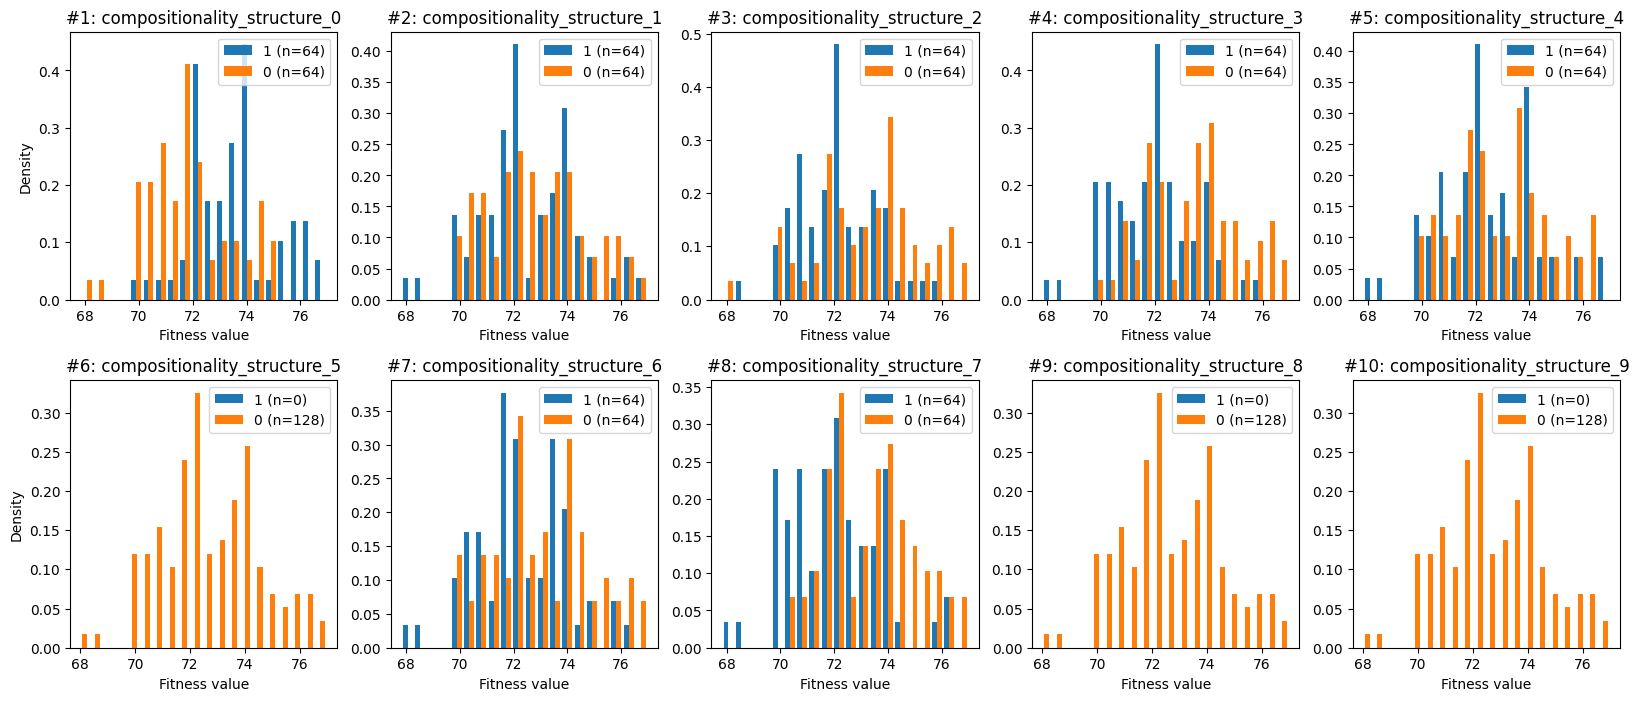

In [10]:
current_ucb = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'evo_sampler_map_elites_ucb_compositionality_final'))
plot_sampler_fitness_trajectory(current_ucb, 'Current, MAP-Elites, UCB Sampling (no `at_end`)')

analyze_archive_fullness(current_ucb)

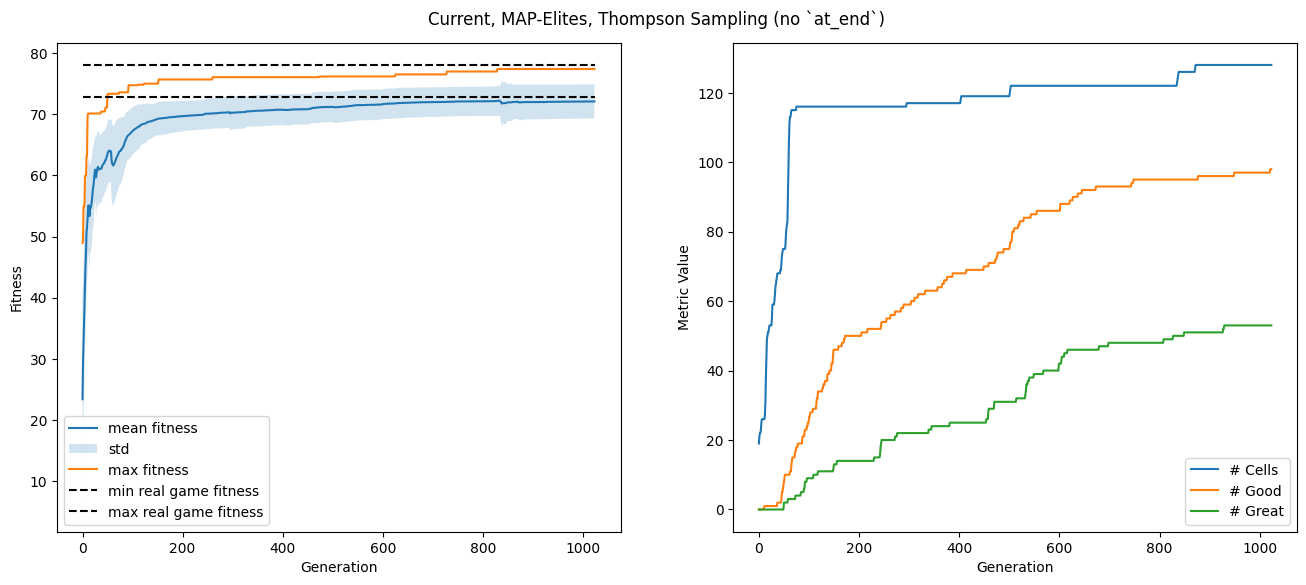

## Archive fullness analysis

Ttoal of 128 samples in archive, 10 features

### Results by feature

- compositionality_structure_0:
    - =0: 71.364 ± 2.562 (n=64)
    - =1: 72.882 ± 2.795 (n=64)
- compositionality_structure_1:
    - =0: 73.299 ± 2.291 (n=64)
    - =1: 70.947 ± 2.741 (n=64)
- compositionality_structure_2:
    - =0: 72.875 ± 2.801 (n=64)
    - =1: 71.370 ± 2.559 (n=64)
- compositionality_structure_3:
    - =0: 73.054 ± 2.867 (n=64)
    - =1: 71.191 ± 2.360 (n=64)
- compositionality_structure_4:
    - =0: 72.954 ± 2.270 (n=64)
    - =1: 71.291 ± 2.999 (n=64)
- compositionality_structure_5:
    - =0: 72.123 ± 2.786 (n=128)
- compositionality_structure_6:
    - =0: 73.052 ± 2.473 (n=64)
    - =1: 71.193 ± 2.772 (n=64)
- compositionality_structure_7:
    - =0: 73.259 ± 2.141 (n=64)
    - =1: 70.987 ± 2.891 (n=64)
- compositionality_structure_8:
    - =0: 72.123 ± 2.786 (n=128)
- compositionality_structure_9:
    - =0: 72.123 ± 2.786 (n=128)

### Results by set feature count

- set-count=0: 74.794 ± 0.000 (n=1 / 1)
- set-count=1: 75.050 ± 0.958 (n=7 / 10)
- set-count=2: 74.358 ± 1.837 (n=21 / 45)
- set-count=3: 73.061 ± 2.339 (n=35 / 120)
- set-count=4: 71.471 ± 2.163 (n=35 / 210)
- set-count=5: 69.900 ± 1.590 (n=21 / 252)
- set-count=6: 68.398 ± 2.228 (n=7 / 210)
- set-count=7: 64.720 ± 0.000 (n=1 / 120)

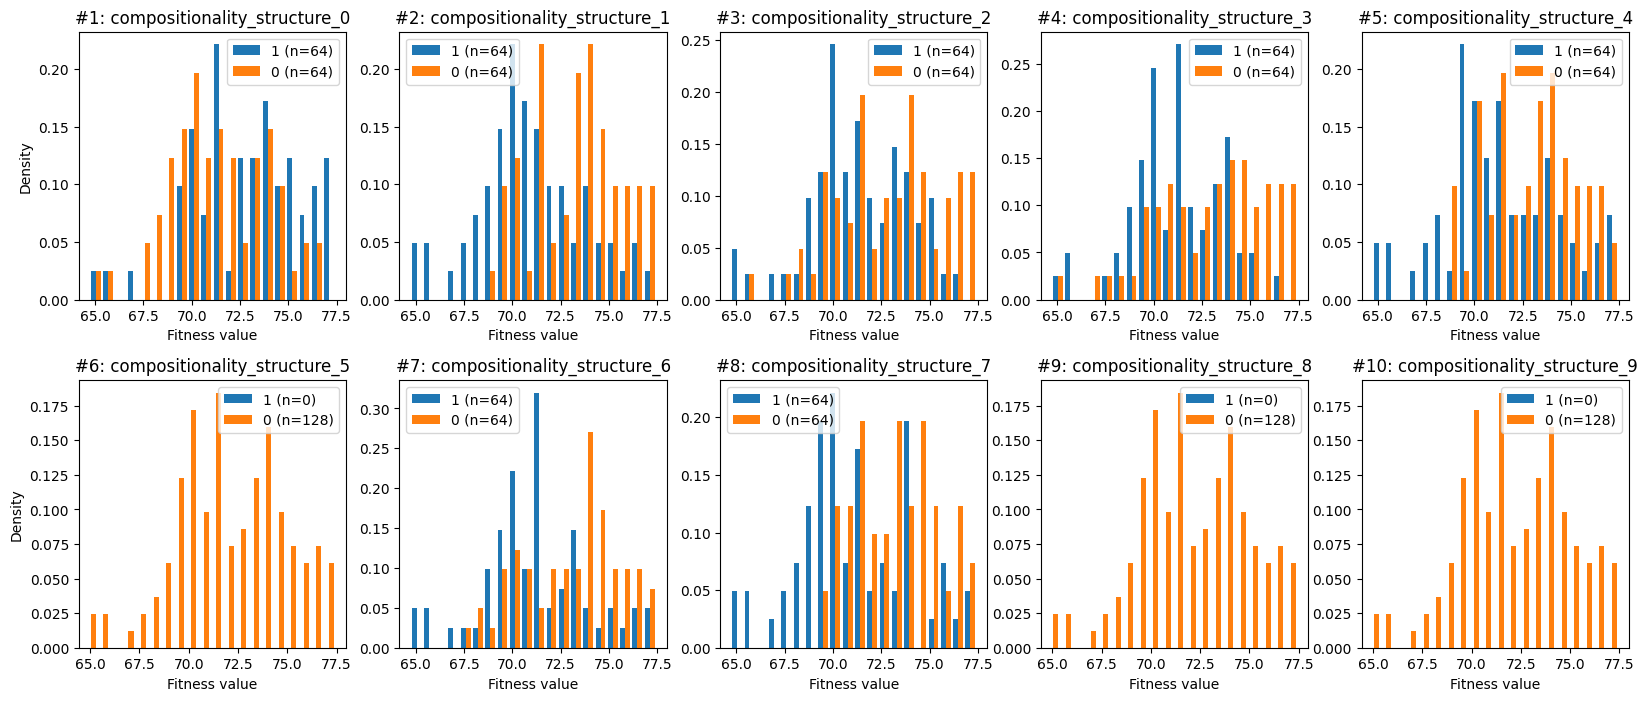

In [25]:
current_thompson = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'evo_sampler_map_elites_thompson_compositionality_final'))
plot_sampler_fitness_trajectory(current_thompson, 'Current, MAP-Elites, Thompson Sampling (no `at_end`)')

analyze_archive_fullness(current_thompson)

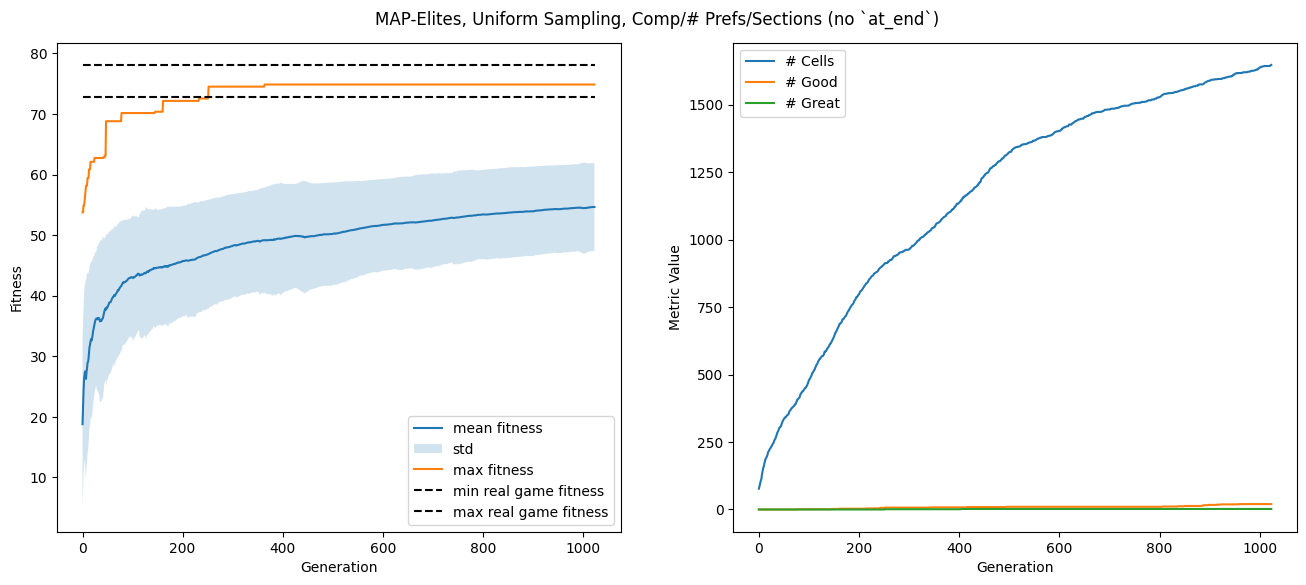

## Archive fullness analysis

Ttoal of 1647 samples in archive, 15 features

### Results by feature

- num_preferences_defined_1:
    - =0: 53.709 ± 6.664 (n=1414)
    - =1: 60.226 ± 8.228 (n=233)
- num_preferences_defined_2:
    - =0: 54.033 ± 7.516 (n=1196)
    - =1: 56.217 ± 6.308 (n=451)
- num_preferences_defined_3:
    - =0: 54.809 ± 7.754 (n=1164)
    - =1: 54.202 ± 5.925 (n=483)
- compositionality_structure_0:
    - =0: 55.274 ± 7.120 (n=923)
    - =1: 53.811 ± 7.377 (n=724)
- compositionality_structure_1:
    - =0: 57.142 ± 6.234 (n=920)
    - =1: 51.453 ± 7.245 (n=727)
- compositionality_structure_2:
    - =0: 54.262 ± 7.364 (n=837)
    - =1: 55.012 ± 7.152 (n=810)
- compositionality_structure_3:
    - =0: 54.864 ± 7.212 (n=846)
    - =1: 54.385 ± 7.324 (n=801)
- compositionality_structure_4:
    - =0: 56.191 ± 6.897 (n=875)
    - =1: 52.863 ± 7.278 (n=772)
- compositionality_structure_5:
    - =0: 54.631 ± 7.271 (n=1647)
- compositionality_structure_6:
    - =0: 56.515 ± 6.702 (n=919)
    - =1: 52.253 ± 7.263 (n=728)
- compositionality_structure_7:
    - =0: 55.891 ± 7.120 (n=879)
    - =1: 53.189 ± 7.172 (n=768)
- compositionality_structure_8:
    - =0: 54.631 ± 7.271 (n=1647)
- compositionality_structure_9:
    - =0: 54.631 ± 7.271 (n=1647)
- section_doesnt_exist_setup:
    - =0: 52.237 ± 7.591 (n=832)
    - =1: 57.075 ± 6.015 (n=815)
- section_doesnt_exist_terminal:
    - =0: 56.080 ± 7.812 (n=842)
    - =1: 53.115 ± 6.310 (n=805)

### Results by set feature count

- set-count=0: 55.606 ± 0.000 (n=1 / 1)
- set-count=1: 55.449 ± 5.717 (n=12 / 15)
- set-count=2: 56.229 ± 6.187 (n=63 / 105)
- set-count=3: 56.857 ± 6.943 (n=191 / 455)
- set-count=4: 56.200 ± 7.771 (n=363 / 1365)
- set-count=5: 55.225 ± 7.375 (n=441 / 3003)
- set-count=6: 53.365 ± 6.640 (n=344 / 5005)
- set-count=7: 51.095 ± 5.902 (n=177 / 6435)
- set-count=8: 49.163 ± 4.593 (n=49 / 6435)
- set-count=9: 48.136 ± 4.565 (n=6 / 5005)

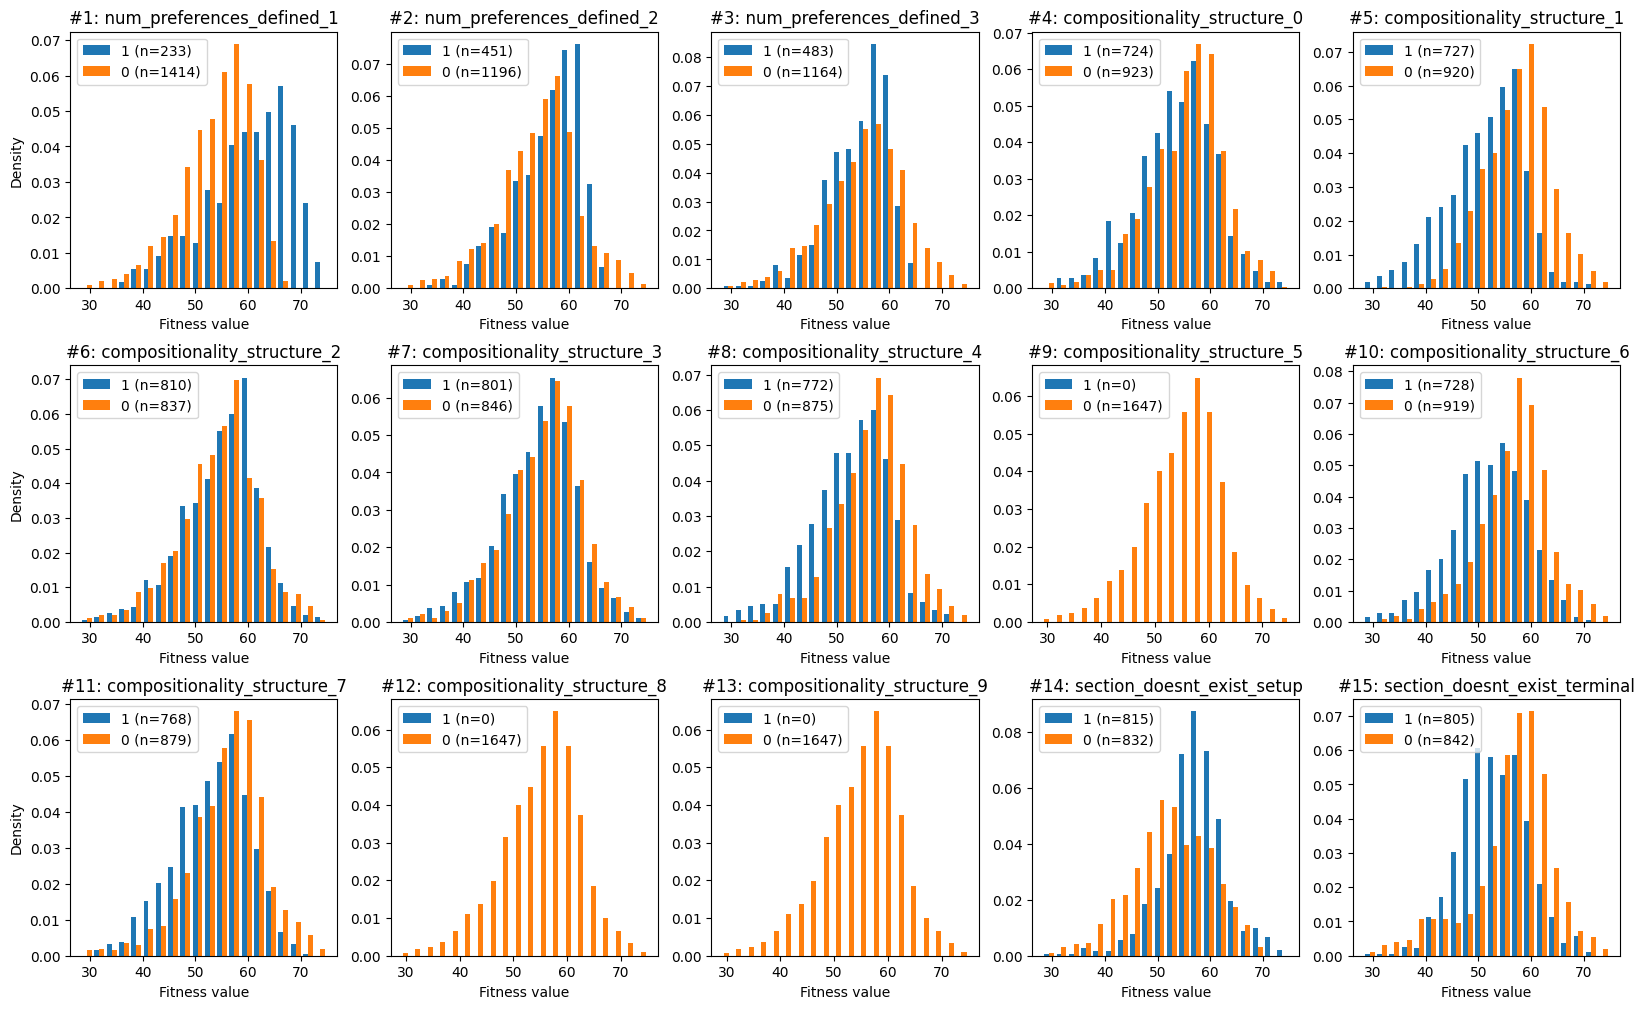

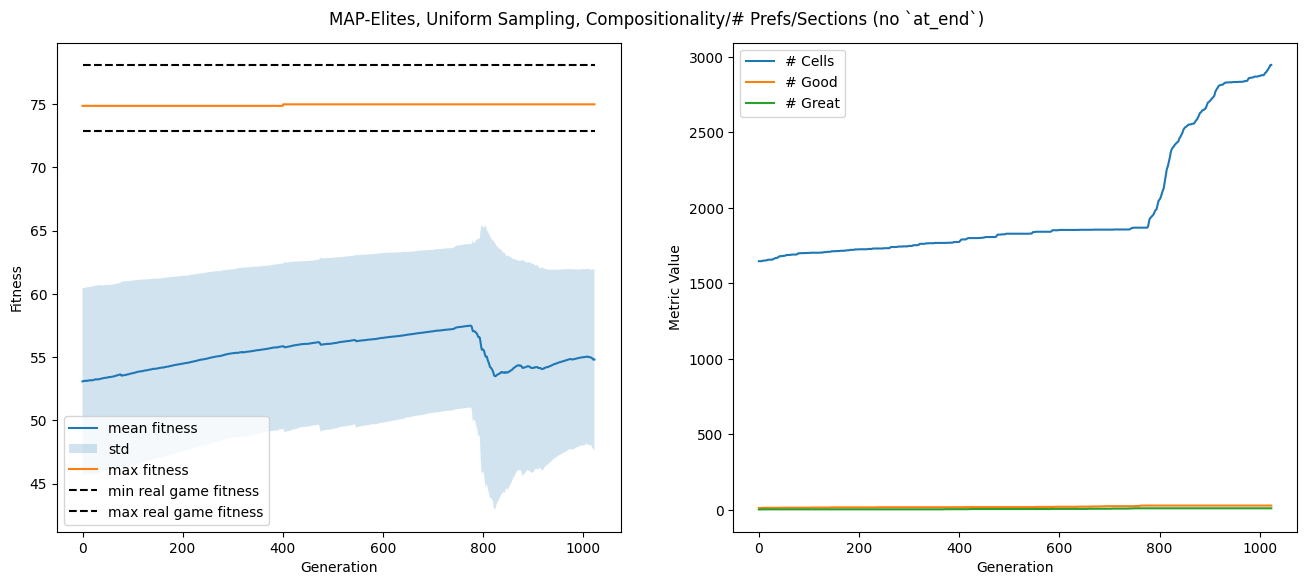

## Archive fullness analysis

Ttoal of 2947 samples in archive, 15 features

### Results by feature

- num_preferences_defined_1:
    - =0: 53.786 ± 6.588 (n=2512)
    - =1: 60.711 ± 7.046 (n=435)
- num_preferences_defined_2:
    - =0: 54.626 ± 7.243 (n=2172)
    - =1: 55.317 ± 6.641 (n=775)
- num_preferences_defined_3:
    - =0: 54.828 ± 7.521 (n=2086)
    - =1: 54.759 ± 5.941 (n=861)
- compositionality_structure_0:
    - =0: 54.975 ± 6.709 (n=1545)
    - =1: 54.624 ± 7.495 (n=1402)
- compositionality_structure_1:
    - =0: 56.269 ± 6.513 (n=1614)
    - =1: 53.039 ± 7.366 (n=1333)
- compositionality_structure_2:
    - =0: 54.469 ± 7.184 (n=1492)
    - =1: 55.156 ± 6.988 (n=1455)
- compositionality_structure_3:
    - =0: 55.191 ± 6.832 (n=1519)
    - =1: 54.400 ± 7.345 (n=1428)
- compositionality_structure_4:
    - =0: 56.867 ± 6.353 (n=1568)
    - =1: 52.467 ± 7.171 (n=1379)
- compositionality_structure_5:
    - =0: 55.404 ± 7.103 (n=2577)
    - =1: 50.656 ± 5.473 (n=370)
- compositionality_structure_6:
    - =0: 55.828 ± 6.867 (n=1617)
    - =1: 53.568 ± 7.172 (n=1330)
- compositionality_structure_7:
    - =0: 55.860 ± 6.675 (n=1534)
    - =1: 53.666 ± 7.358 (n=1413)
- compositionality_structure_8:
    - =0: 55.557 ± 6.803 (n=2603)
    - =1: 49.140 ± 6.695 (n=344)
- compositionality_structure_9:
    - =0: 55.392 ± 7.219 (n=2585)
    - =1: 50.637 ± 4.232 (n=362)
- section_doesnt_exist_setup:
    - =0: 54.390 ± 6.454 (n=907)
    - =1: 54.994 ± 7.356 (n=2040)
- section_doesnt_exist_terminal:
    - =0: 54.150 ± 7.510 (n=2015)
    - =1: 56.231 ± 5.858 (n=932)

### Results by set feature count

- set-count=0: 55.651 ± 0.000 (n=1 / 1)
- set-count=1: 56.709 ± 4.309 (n=12 / 15)
- set-count=2: 57.658 ± 5.072 (n=66 / 105)
- set-count=3: 57.884 ± 5.830 (n=222 / 455)
- set-count=4: 57.191 ± 6.298 (n=499 / 1365)
- set-count=5: 55.713 ± 6.760 (n=749 / 3003)
- set-count=6: 54.072 ± 7.087 (n=728 / 5005)
- set-count=7: 52.293 ± 6.969 (n=459 / 6435)
- set-count=8: 50.128 ± 7.201 (n=175 / 6435)
- set-count=9: 47.870 ± 7.156 (n=33 / 5005)
- set-count=10: 46.769 ± 8.981 (n=3 / 3003)

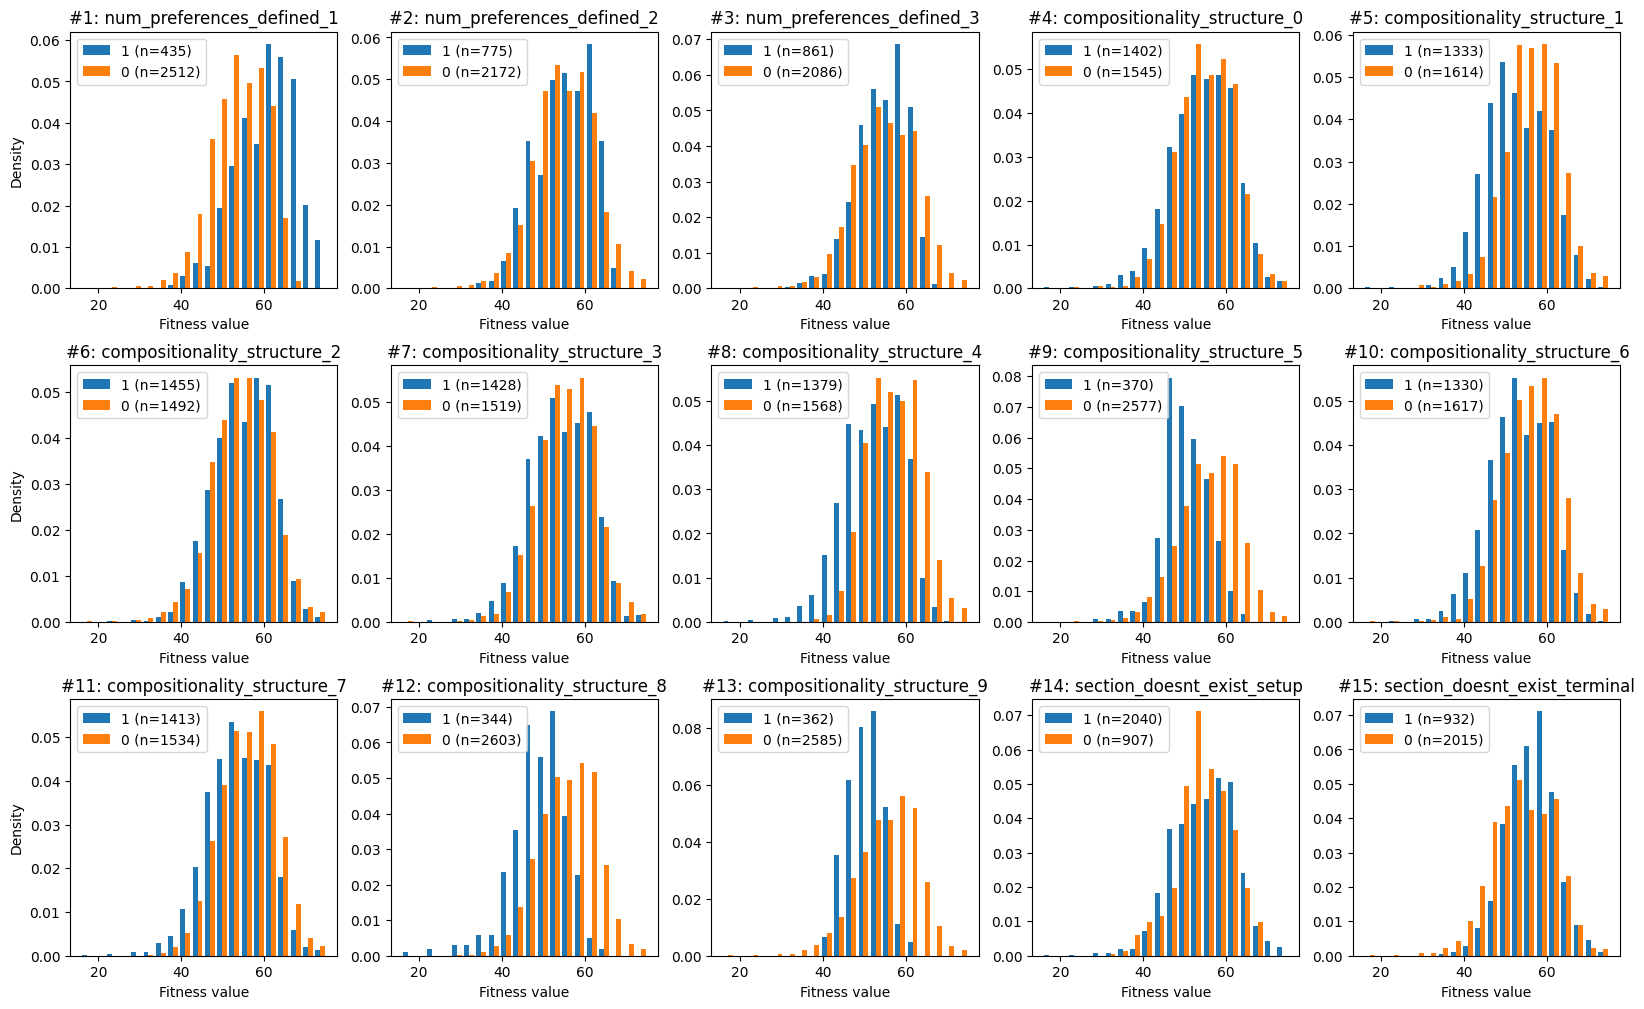

In [24]:
uniform_comp_prefs_sections = typing.cast(MAPElitesSampler, utils.load_data('2023_05_09', 'samples', 'evo_sampler_map_elites_uniform_compositionality_prefs_sections_final'))
plot_sampler_fitness_trajectory(uniform_comp_prefs_sections, 'MAP-Elites, Uniform Sampling, Comp/# Prefs/Sections (no `at_end`)')

analyze_archive_fullness(uniform_comp_prefs_sections)

uniform_comp_prefs_sections = typing.cast(MAPElitesSampler, utils.load_data('2023_05_10', 'samples', 'evo_sampler_map_elites_uniform_compositionality_prefs_sections_ucb_resume_final'))
plot_sampler_fitness_trajectory(uniform_comp_prefs_sections, 'MAP-Elites, Uniform Sampling, Compositionality/# Prefs/Sections (no `at_end`)')

analyze_archive_fullness(uniform_comp_prefs_sections)



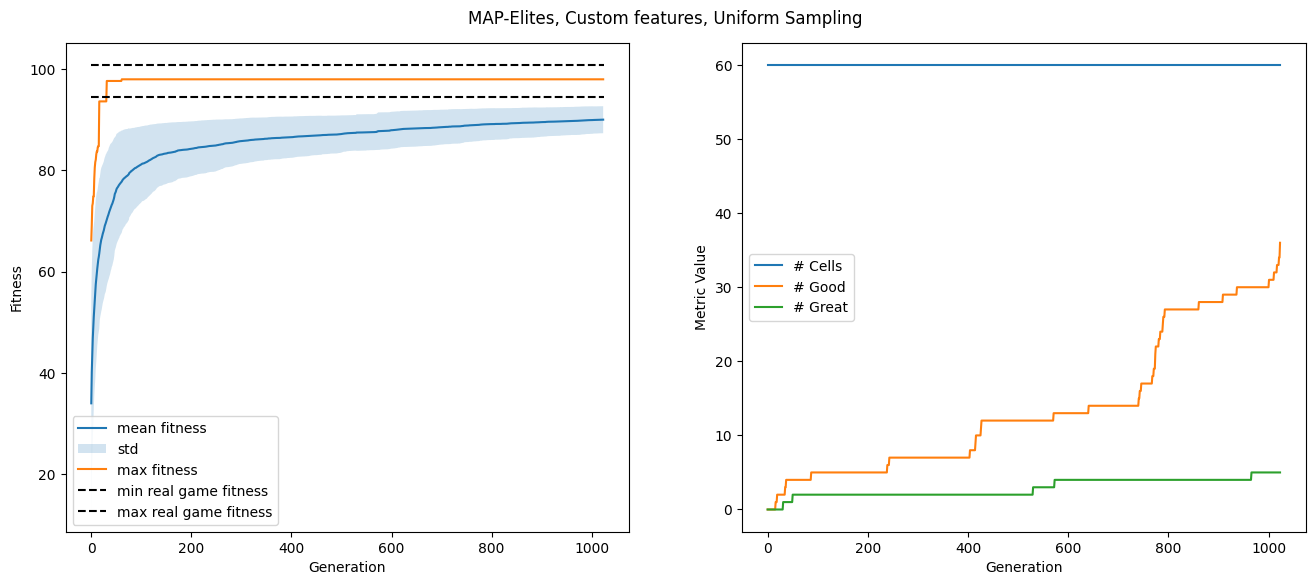

In [20]:
uniform_custom_features = typing.cast(MAPElitesSampler, utils.load_data('2023_05_10', 'samples', 'evo_sampler_map_elites_uniform_custom_features_final'))
plot_sampler_fitness_trajectory(uniform_custom_features, 'MAP-Elites, Custom features, Uniform Sampling',
    min_real_game_fitness=94.4415, max_real_game_fitness=100.7793)

# analyze_archive_fullness(uniform_comp_prefs_sections)

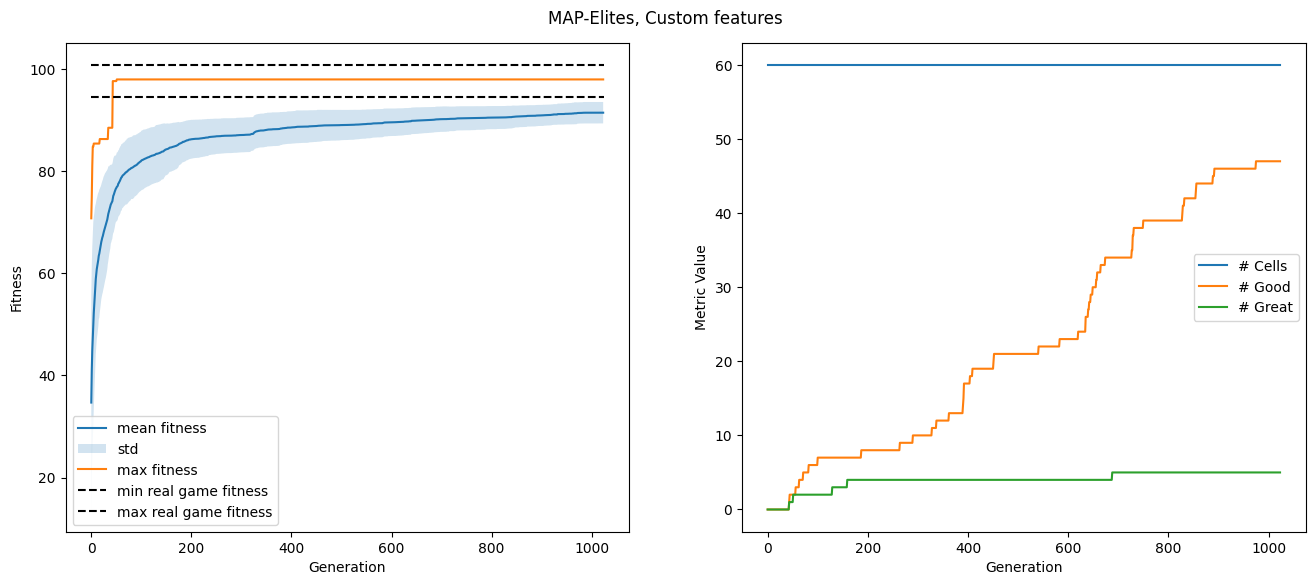

In [17]:
ucb_custom_features = typing.cast(MAPElitesSampler, utils.load_data('2023_05_10', 'samples', 'evo_sampler_map_elites_ucb_custom_features_final'))
plot_sampler_fitness_trajectory(ucb_custom_features, 'MAP-Elites, Custom features',
    min_real_game_fitness=94.4415, max_real_game_fitness=100.7793)

# analyze_archive_fullness(uniform_comp_prefs_sections)

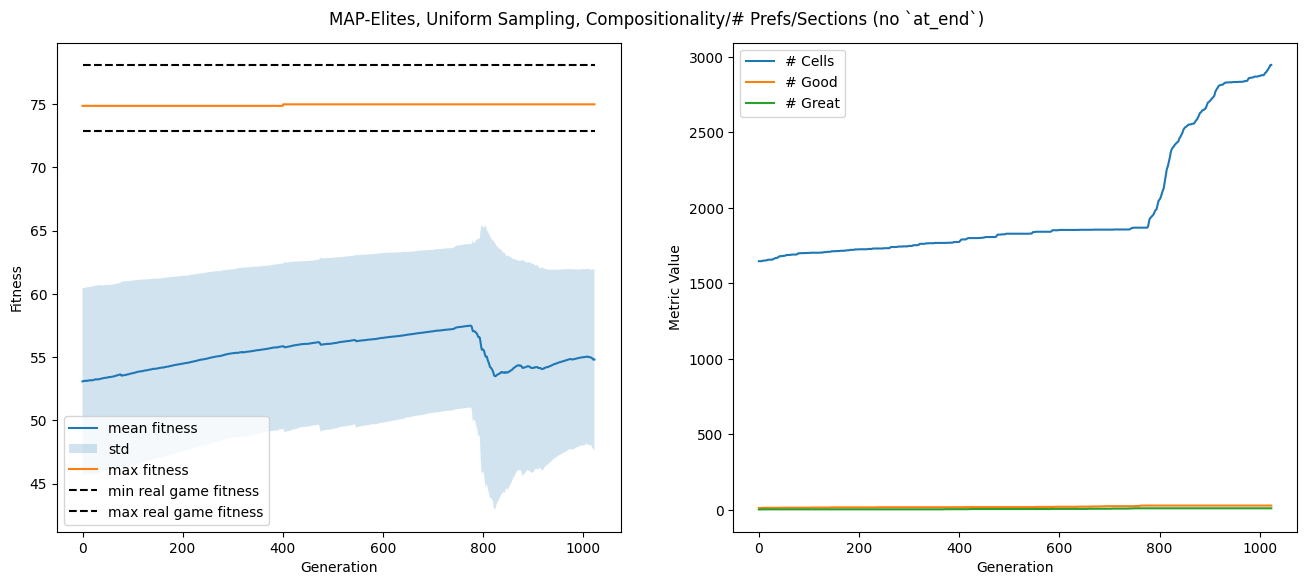

## Archive fullness analysis

Ttoal of 2947 samples in archive, 15 features

### Results by feature

- num_preferences_defined_1:
    - =0: 53.786 ± 6.588 (n=2512)
    - =1: 60.711 ± 7.046 (n=435)
- num_preferences_defined_2:
    - =0: 54.626 ± 7.243 (n=2172)
    - =1: 55.317 ± 6.641 (n=775)
- num_preferences_defined_3:
    - =0: 54.828 ± 7.521 (n=2086)
    - =1: 54.759 ± 5.941 (n=861)
- compositionality_structure_0:
    - =0: 54.975 ± 6.709 (n=1545)
    - =1: 54.624 ± 7.495 (n=1402)
- compositionality_structure_1:
    - =0: 56.269 ± 6.513 (n=1614)
    - =1: 53.039 ± 7.366 (n=1333)
- compositionality_structure_2:
    - =0: 54.469 ± 7.184 (n=1492)
    - =1: 55.156 ± 6.988 (n=1455)
- compositionality_structure_3:
    - =0: 55.191 ± 6.832 (n=1519)
    - =1: 54.400 ± 7.345 (n=1428)
- compositionality_structure_4:
    - =0: 56.867 ± 6.353 (n=1568)
    - =1: 52.467 ± 7.171 (n=1379)
- compositionality_structure_5:
    - =0: 55.404 ± 7.103 (n=2577)
    - =1: 50.656 ± 5.473 (n=370)
- compositionality_structure_6:
    - =0: 55.828 ± 6.867 (n=1617)
    - =1: 53.568 ± 7.172 (n=1330)
- compositionality_structure_7:
    - =0: 55.860 ± 6.675 (n=1534)
    - =1: 53.666 ± 7.358 (n=1413)
- compositionality_structure_8:
    - =0: 55.557 ± 6.803 (n=2603)
    - =1: 49.140 ± 6.695 (n=344)
- compositionality_structure_9:
    - =0: 55.392 ± 7.219 (n=2585)
    - =1: 50.637 ± 4.232 (n=362)
- section_doesnt_exist_setup:
    - =0: 54.390 ± 6.454 (n=907)
    - =1: 54.994 ± 7.356 (n=2040)
- section_doesnt_exist_terminal:
    - =0: 54.150 ± 7.510 (n=2015)
    - =1: 56.231 ± 5.858 (n=932)

### Results by set feature count

- set-count=0: 55.651 ± 0.000 (n=1 / 1)
- set-count=1: 56.709 ± 4.309 (n=12 / 15)
- set-count=2: 57.658 ± 5.072 (n=66 / 105)
- set-count=3: 57.884 ± 5.830 (n=222 / 455)
- set-count=4: 57.191 ± 6.298 (n=499 / 1365)
- set-count=5: 55.713 ± 6.760 (n=749 / 3003)
- set-count=6: 54.072 ± 7.087 (n=728 / 5005)
- set-count=7: 52.293 ± 6.969 (n=459 / 6435)
- set-count=8: 50.128 ± 7.201 (n=175 / 6435)
- set-count=9: 47.870 ± 7.156 (n=33 / 5005)
- set-count=10: 46.769 ± 8.981 (n=3 / 3003)

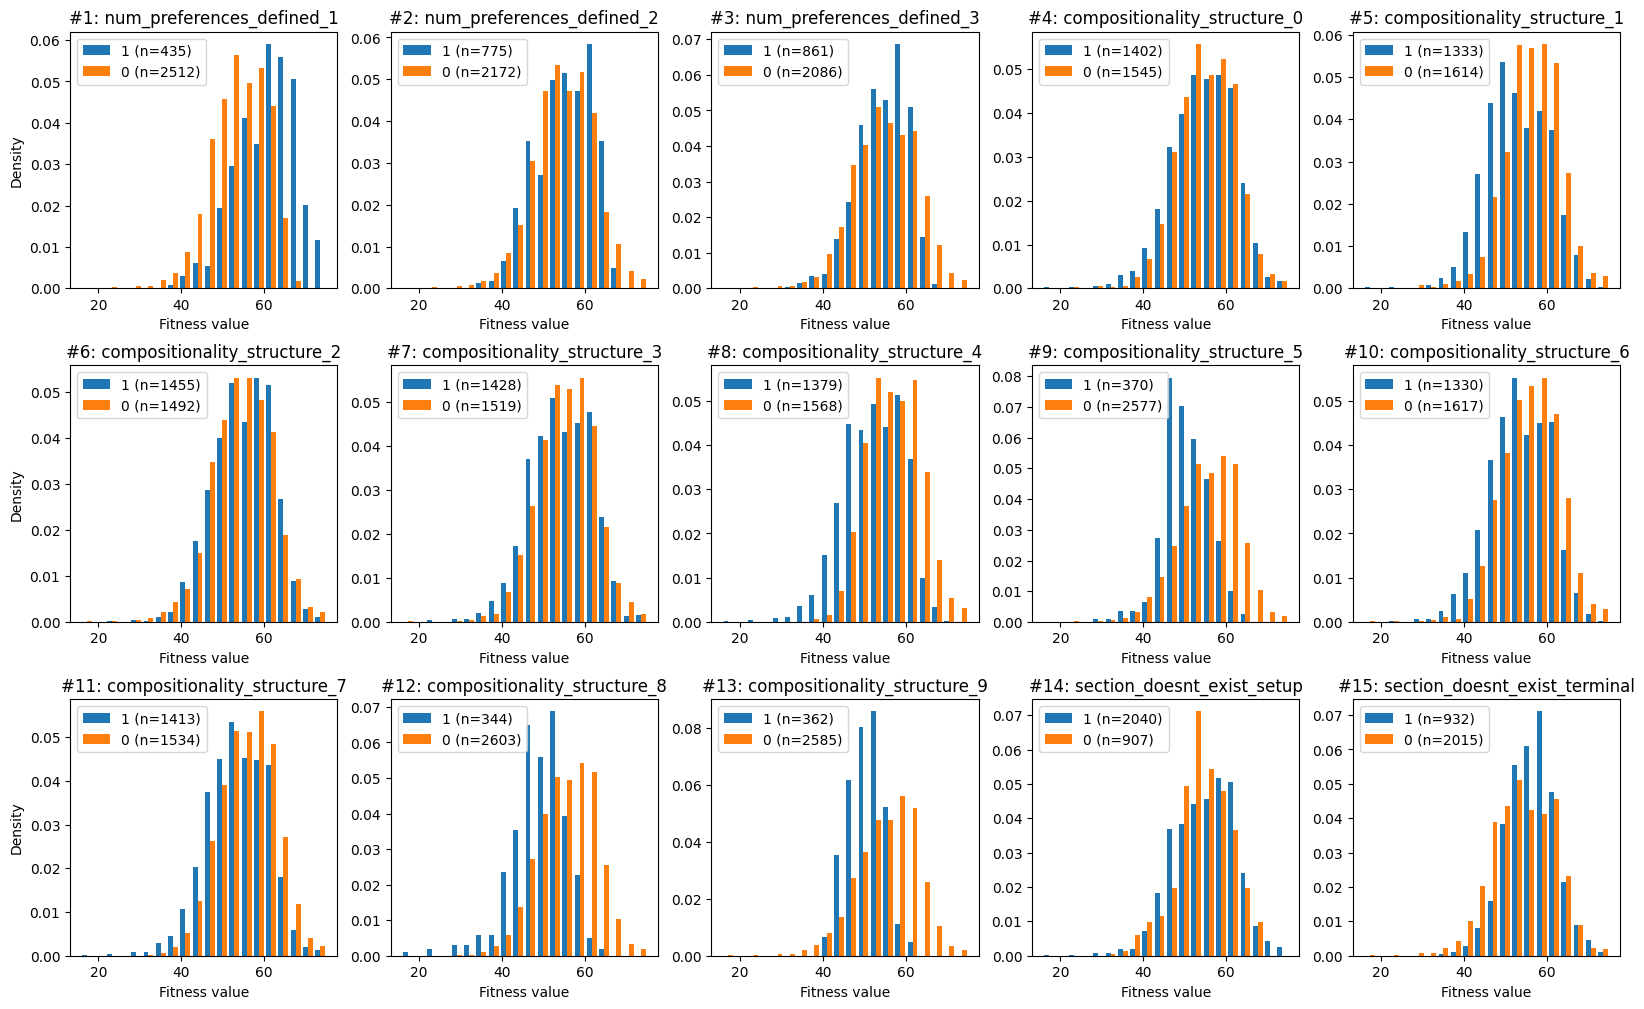

In [ ]:
evo_sampler_map_elites_ucb = typing.cast(MAPElitesSampler, utils.load_data('2023_05_08', 'samples', 'evo_sampler_map_elites_ucb_2_final'))
plot_sampler_fitness_trajectory(evo_sampler_map_elites_ucb, 'MAP-Elites, UCB Sampling')

In [ ]:
evo_sampler_map_elites_ucb_resume = typing.cast(MAPElitesSampler, utils.load_data('2023_05_08', 'samples', 'evo_sampler_map_elites_ucb_2_resume_final'))
plot_sampler_fitness_trajectory(evo_sampler_map_elites_ucb_resume, 'MAP-Elites, UCB Sampling')

In [ ]:
evo_sampler_map_elites_thompson_no_at_end = typing.cast(MAPElitesSampler, utils.load_data('2023_05_05', 'samples', 'evo_sampler_map_elites_thompson_from_fitness_rank_final'))
plot_sampler_fitness_trajectory(evo_sampler_map_elites_thompson_no_at_end, 'MAP-Elites, Thompson Sampling (no `at_end`)')

In [ ]:
evo_sampler_map_elites_fitness_rank_no_at_end = typing.cast(MAPElitesSampler, utils.load_data('2023_05_05', 'samples', 'evo_sampler_map_elites_fitness_rank_resume_final'))
plot_sampler_fitness_trajectory(evo_sampler_map_elites_fitness_rank_no_at_end, 'MAP-Elites, Fitness Rank Sampling (no `at_end`)')

In [ ]:
def visualize_sample_from_old_model(
    old_model: MAPElitesSampler, new_model: MAPElitesSampler, top_index: int, 
    sample_features: typing.Optional[typing.Dict[str, int]] = None,
    n_features_on: typing.Optional[int] = None,
    feature_keywords_to_print: typing.Optional[typing.List[str]] = None,
    n_similar_real_games_to_print: int = 3
    ):

    old_model_index_key = old_model.top_sample_key(top_index, sample_features, n_features_on)
    key_dict = {f: (old_model_index_key >> i) % 2 for i, f in enumerate(old_model.map_elites_feature_names)}
    print(f'Sample features for key {old_model_index_key}:')
    for feature_name, feature_value in key_dict.items():
        print(f'{feature_name}: {feature_value}')

    old_model_index_game = old_model.population[old_model_index_key]

    new_model._visualize_sample(old_model_index_game, feature_keywords_to_print=feature_keywords_to_print)
    print_nearest_real_games(old_model_index_game, n_similar_real_games_to_print)



In [ ]:
visualize_sample_from_old_model(original_uniform, current_uniform, 3)

In [22]:
# model = evo_sampler_map_elites_fitness_rank_no_at_end
model = current_uniform
index = 1
n_features_on = 5
feature_keywords_to_print = ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3 

key = model.visualize_top_sample(index, feature_keywords_to_print=feature_keywords_to_print, n_features_on=n_features_on)
print_nearest_real_games(model.population[key], n_similar_real_games_to_print)

AttributeError: 'MAPElitesSampler' object has no attribute 'key_type'

In [ ]:
analyze_archive_fullness(current_uniform)

In [ ]:
# features = dict(section_doesnt_exist_setup=0)
features = dict(num_preferences_defined_2=1)

key = evo_sampler_map_elites_fitness_rank_no_at_end.visualize_top_sample_with_features(features, 1)
if key is not None:
    print_nearest_real_games(evo_sampler_map_elites_fitness_rank_no_at_end.population[key], 3)

In [ ]:
for k, g in evo_sampler_map_elites_ucb.population.items():
    f = evo_sampler_map_elites_ucb._score_proposal(g)
    if not np.isclose(f, evo_sampler_map_elites_ucb.fitness_values[k]):
        print(k, f, evo_sampler_map_elites_ucb.fitness_values[k])

In [ ]:
def real_games_to_keys(map_elites_sampler: MAPElitesSampler, real_asts: typing.List[tatsu.ast.AST]) -> typing.List[str]:
    return set([map_elites_sampler._features_to_key(map_elites_sampler._proposal_to_features(ast)) for ast in real_asts])
    

real_game_keys = real_games_to_keys(evo_sampler_map_elites_no_at_end, game_asts)
high_quality_sample_keys = set([k for k, v in evo_sampler_map_elites_no_at_end.fitness_values.items() if v > 75])
high_quality_no_real_game_keys = high_quality_sample_keys - real_game_keys
print(len(real_game_keys), len(high_quality_sample_keys), len(real_game_keys.intersection(high_quality_sample_keys)), len(high_quality_no_real_game_keys))


In [ ]:
i = 9
high_quality_no_real_game_keys_list = list(high_quality_no_real_game_keys)
key = high_quality_no_real_game_keys_list[i]

evo_sampler_map_elites_no_at_end._visualize_sample_by_key(key)
print_nearest_real_games(evo_sampler_map_elites_no_at_end.population[key], 3)

In [ ]:
def count_set_bits(n): 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in current_uniform.fitness_values.items():
    key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
threshold = 70

def count_set_bits(n):
 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in evo_sampler_map_elites_ucb.fitness_values.items():
    if fitness > threshold:
        key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [35]:
from src.evolutionary_sampler_behavioral_features import build_behavioral_features_featurizer, BASIC_BINNED, BASIC_WITH_NODE_DEPTH


featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(current_thompson.population[current_thompson.top_sample_key(i)], 'interactive-beta.pddl', return_row=False) for i in range(1, 51)]
d_generated = featurizer.to_df()
d_generated.describe()

,node_count,unique_objects_referenced,unique_predicates_referenced,mean_node_depth
count,50.000000,50.000000,50.000000,50.000000
mean,1.140000,1.020000,1.860000,7.551290
std,0.670364,0.795138,0.926041,0.596206
min,0.000000,0.000000,0.000000,6.239130
25%,1.000000,0.000000,1.000000,7.256013
50%,1.000000,1.000000,2.000000,7.691176
75%,2.000000,2.000000,3.000000,8.008523
max,2.000000,3.000000,3.000000,8.347826


In [36]:
featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
d_real = featurizer.to_df()

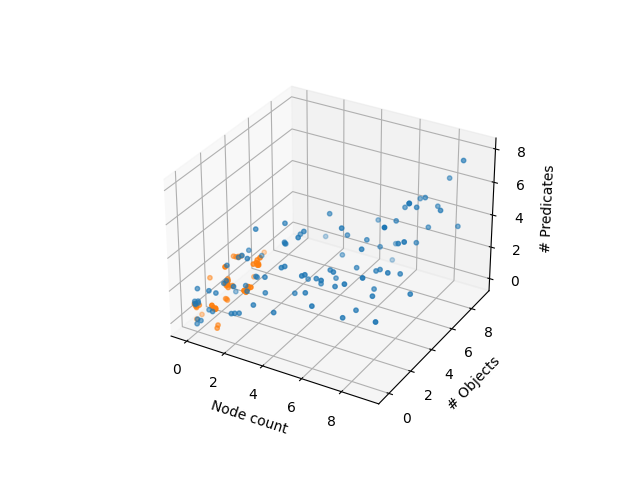

In [39]:
%matplotlib widget


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
generated_values = d_generated[featurizer.headers[4:-1]].values.T.astype(float)
real_values = d_real[featurizer.headers[4:-1]].values.T.astype(float)
generated_values += np.random.normal(0, 0.1, size=generated_values.shape)
real_values += np.random.normal(0, 0.1, size=real_values.shape)
ax.scatter(*real_values, s=10)
ax.scatter(*generated_values, s=10)
ax.set_xlabel('Node count')
ax.set_ylabel('# Objects')
ax.set_zlabel('# Predicates')

plt.show()

In [43]:
from src.evolutionary_sampler_behavioral_features import *
(len(NODE_COUNT_BINS) + 1) * (len(UNIQUE_OBJECT_REFERENCES_BINS) + 1) * (len(UNIQUE_PREDICATE_REFERENCES_BINS) + 1)

900